importing libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error
sns.set()

In [2]:
data = pd.read_csv('Sleep_Efficiency.csv', parse_dates=True)

TARGET = 'Sleep efficiency'
sleep_efficiency = data[TARGET]
data = data.drop(TARGET, axis=1)
data['Sleep efficiency'] = sleep_efficiency

data = data.drop('ID', axis=1)

TIME = ['Bedtime', 'Wakeup time']
for x in TIME :
    data[x] = pd.to_datetime(data[x], format='%Y-%m-%d %H:%M:%S')
    
data.head()

,Age,Gender,Bedtime,Wakeup time,Sleep duration,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency,Sleep efficiency
0,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,18,70,10,0.0,0.0,0.0,Yes,3.0,0.88
1,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,24,28,53,3.0,0.0,3.0,Yes,3.0,0.66
2,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,20,70,10,1.0,0.0,0.0,No,3.0,0.89
3,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,28,25,52,3.0,50.0,5.0,Yes,1.0,0.51
4,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,27,55,18,3.0,0.0,3.0,No,3.0,0.76


In [3]:
data.shape

(452, 14)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Age                     452 non-null    int64         
 1   Gender                  452 non-null    object        
 2   Bedtime                 452 non-null    datetime64[ns]
 3   Wakeup time             452 non-null    datetime64[ns]
 4   Sleep duration          452 non-null    float64       
 5   REM sleep percentage    452 non-null    int64         
 6   Deep sleep percentage   452 non-null    int64         
 7   Light sleep percentage  452 non-null    int64         
 8   Awakenings              432 non-null    float64       
 9   Caffeine consumption    427 non-null    float64       
 10  Alcohol consumption     436 non-null    float64       
 11  Smoking status          452 non-null    object        
 12  Exercise frequency      446 non-null    float64   

visualization

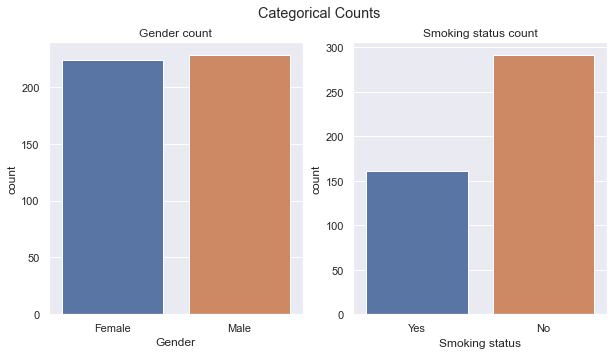

In [5]:
# categorical

CATEGORICAL = list(data.select_dtypes(include='object').columns)
size = len(CATEGORICAL)

fig, ax = plt.subplots(1,size, figsize=(10,5))
fig.suptitle('Categorical Counts')

for num, column in enumerate(CATEGORICAL) :
    sns.countplot(x = data[column], ax=ax[num]) # balanced
    ax[num].set_title(f'{column} count')

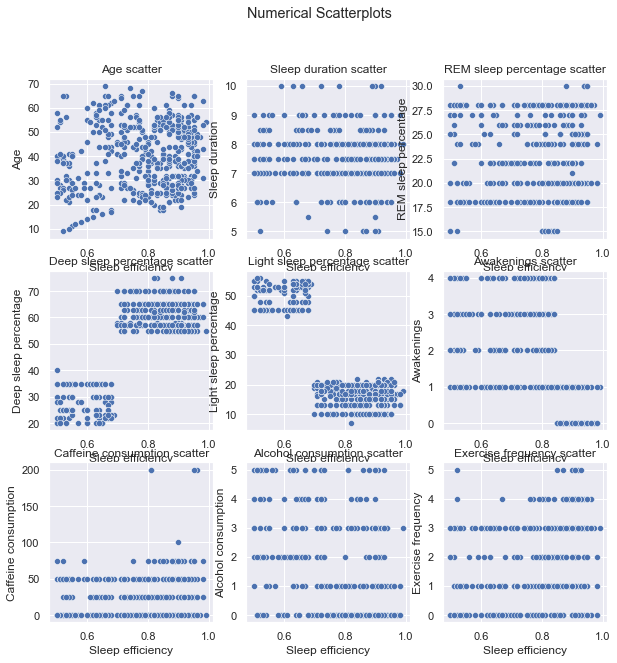

In [6]:
# numerical scatter

NUMERICAL = list(data.drop(TARGET, axis=1).select_dtypes(include='number').columns)
size = len(NUMERICAL)
numerical_for_viz = [NUMERICAL[:3], NUMERICAL[3:6], NUMERICAL[6:]]

x = 3
y = size//x

fig, ax = plt.subplots(x,y, figsize=(10,10))
fig.suptitle('Numerical Scatterplots')

for i in range(x) :
    for j in range(y) :
        sns.scatterplot(x=data[TARGET] , y=data[numerical_for_viz[i][j]], ax=ax[i][j]) # balanced
        ax[i][j].set_title(f'{numerical_for_viz[i][j]} scatter')
    

<AxesSubplot:xlabel='Sleep efficiency', ylabel='Count'>

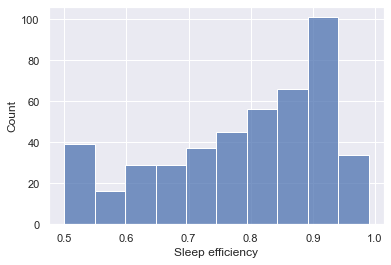

In [8]:
sns.histplot(data=data, x='Sleep efficiency')

In [9]:
data.isna().sum()

Age                        0
Gender                     0
Bedtime                    0
Wakeup time                0
Sleep duration             0
REM sleep percentage       0
Deep sleep percentage      0
Light sleep percentage     0
Awakenings                20
Caffeine consumption      25
Alcohol consumption       16
Smoking status             0
Exercise frequency         6
Sleep efficiency           0
dtype: int64

preprocess

outlier handling

In [11]:
# mikir dlu

pipeline

In [39]:
to_drop = ['Bedtime', 'Wakeup time']
to_impute = ['Awakenings', 'Caffeine consumption', 'Alcohol consumption']

X = data.drop(TARGET, axis=1)
y = data[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=0.2)

class Scaler(BaseEstimator, TransformerMixin) :
    def __init__(self, columns) :
        self.columns = columns
    def fit(self, X, y=None) :
        self.scaler = StandardScaler()
        return self
    def transform(self, X, y=None) :
        X_transform = X.copy()
        X_transform[self.columns] = self.scaler.fit_transform(X_transform[self.columns])
        return X_transform

class Imputer(BaseEstimator, TransformerMixin) :
    def __init__(self, columns, strategy='mean') :
        self.columns = columns
        self.strategy = strategy
    def fit(self, X, y=None) :
        self.imputer = SimpleImputer(strategy=self.strategy)
        return self
    def transform(self, X, y=None) :
        X_transformed = X.copy()
        X_transformed[self.columns] = self.imputer.fit_transform(X_transformed[self.columns])
        return X_transformed

class ColumnDropper(BaseEstimator, TransformerMixin) :
    def __init__(self, columns) :
        self.columns = columns
    def fit(self, X, y=None) :
        return self
    def transform(self, X, y=None) :
        X_transformed = X.drop(self.columns, axis=1)
        return X_transformed

class Encoder(BaseEstimator, TransformerMixin) :
    def __init__(self, features, drop='first') :
        self.features = features
        self.drop = drop
    
    def fit(self, X, y=None) :
        self.encoder = OneHotEncoder(sparse=False, drop=self.drop)
        self.encoder.fit(X[self.features])
        return self

    def transform(self, X) :
        X_transformed = pd.concat([X.drop(columns=self.features).reset_index(drop=True), 
                                   pd.DataFrame(self.encoder.transform(X[self.features]),columns=self.encoder.get_feature_names(self.features))], axis=1)
    
        return X_transformed

pipe = Pipeline([
    ('Drop_features', ColumnDropper(to_drop)),
    ('Encode', Encoder(CATEGORICAL)),
    ('Impute', Imputer(to_impute)),
    ('Standardize', Scaler(NUMERICAL)),

])

# X_preprocessed = pipe.fit_transform(X)
# concat_df = pd.concat([X_preprocessed, y], axis=1)
X_train_preprocessed = pipe.fit_transform(X_train)
X_test_preprocessed = pipe.fit_transform(X_test)
X_train_preprocessed

,Age,Sleep duration,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Exercise frequency,Gender_Male,Smoking status_Yes
0,-0.766634,0.015743,-1.297818,1.101019,-0.988999,-0.473811,0.000000,-0.744684,0.844947,1.0,0.0
1,0.392306,0.015743,-0.285912,0.271232,-0.331730,-0.473811,-0.872381,2.442860,-1.262473,1.0,0.0
2,0.624094,0.584054,0.473017,0.462721,-0.660365,-1.218986,0.015532,-0.744684,1.547420,0.0,0.0
3,0.469569,0.015743,0.473017,0.462721,-0.660365,-0.473811,-0.872381,-0.744684,0.844947,0.0,0.0
4,1.087670,-0.552569,-0.285912,-1.962809,1.968713,1.761714,-0.872381,-0.744684,-1.262473,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
356,-0.380321,0.015743,1.231946,0.462721,-0.528911,-0.473811,0.000000,-0.744684,-0.560000,0.0,0.0
357,-0.843897,0.015743,0.473017,-1.579830,1.640079,-0.473811,1.791359,-0.107175,0.142473,0.0,1.0
358,0.933145,0.584054,-1.297818,0.781870,-0.660365,0.000000,0.903445,-0.107175,0.844947,1.0,0.0
359,1.164933,0.015743,-1.297818,0.462721,-0.200276,-1.218986,-0.872381,-0.744684,0.844947,1.0,0.0


<AxesSubplot:xlabel='Age', ylabel='Count'>

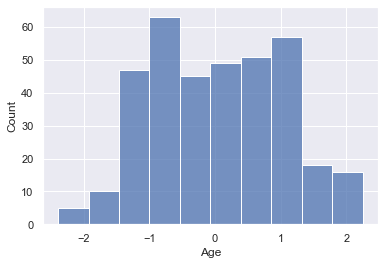

In [14]:
sns.histplot(data=X_train_preprocessed, x='Age')

model

In [15]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

Learning rate set to 0.107582
0:	learn: 0.1259496	total: 2.24ms	remaining: 559ms
1:	learn: 0.1161220	total: 3.05ms	remaining: 378ms
2:	learn: 0.1071292	total: 4.85ms	remaining: 400ms
3:	learn: 0.0995542	total: 6.93ms	remaining: 426ms
4:	learn: 0.0927450	total: 8.1ms	remaining: 397ms
5:	learn: 0.0868601	total: 9.11ms	remaining: 370ms
6:	learn: 0.0823723	total: 9.94ms	remaining: 345ms
7:	learn: 0.0778888	total: 10.8ms	remaining: 327ms
8:	learn: 0.0739012	total: 11.7ms	remaining: 312ms
9:	learn: 0.0708699	total: 15.3ms	remaining: 367ms
10:	learn: 0.0681014	total: 16.6ms	remaining: 362ms
11:	learn: 0.0654877	total: 17.6ms	remaining: 349ms
12:	learn: 0.0625939	total: 18.4ms	remaining: 336ms
13:	learn: 0.0603493	total: 20.4ms	remaining: 344ms
14:	learn: 0.0582960	total: 21.7ms	remaining: 340ms
15:	learn: 0.0568007	total: 24.5ms	remaining: 359ms
16:	learn: 0.0555076	total: 25.5ms	remaining: 350ms
17:	learn: 0.0543746	total: 26.7ms	remaining: 344ms
18:	learn: 0.0531318	total: 28.6ms	remaining:

<AxesSubplot:>

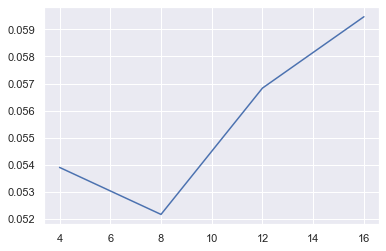

In [18]:
max_depths = [i for i in range(4,17,4)]
container = []

for i in max_depths :
    model_ = CatBoostRegressor(max_depth=i, iterations=250)
    model_.fit(X_train_preprocessed, y_train)
    predictions = model_.predict(X_test_preprocessed)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    container.append(rmse)

sns.lineplot(y=container, x=max_depths)


catboost

In [54]:
cat_model = CatBoostRegressor(max_depth=8, iterations=250)
cat_model.fit(X_train_preprocessed, y_train)
cat_predict = cat_model.predict(X_test_preprocessed)
rmse = np.sqrt(mean_squared_error(y_test, cat_predict))
print(rmse)

Learning rate set to 0.107582
0:	learn: 0.1271054	total: 6.1ms	remaining: 1.52s
1:	learn: 0.1176668	total: 9.25ms	remaining: 1.15s
2:	learn: 0.1095129	total: 14.2ms	remaining: 1.17s
3:	learn: 0.1033445	total: 17.7ms	remaining: 1.09s
4:	learn: 0.0969750	total: 21.1ms	remaining: 1.03s
5:	learn: 0.0904503	total: 22.1ms	remaining: 899ms
6:	learn: 0.0852250	total: 24.5ms	remaining: 850ms
7:	learn: 0.0806778	total: 32.6ms	remaining: 986ms
8:	learn: 0.0766572	total: 37.6ms	remaining: 1.01s
9:	learn: 0.0724037	total: 39.5ms	remaining: 949ms
10:	learn: 0.0692049	total: 46.6ms	remaining: 1.01s
11:	learn: 0.0664989	total: 50.2ms	remaining: 995ms
12:	learn: 0.0636068	total: 54.3ms	remaining: 991ms
13:	learn: 0.0613247	total: 64.7ms	remaining: 1.09s
14:	learn: 0.0590919	total: 68.3ms	remaining: 1.07s
15:	learn: 0.0568304	total: 73.5ms	remaining: 1.07s
16:	learn: 0.0548311	total: 76.6ms	remaining: 1.05s
17:	learn: 0.0529644	total: 79.7ms	remaining: 1.03s
18:	learn: 0.0512352	total: 82ms	remaining: 9

<AxesSubplot:xlabel='Sleep efficiency', ylabel='Age'>

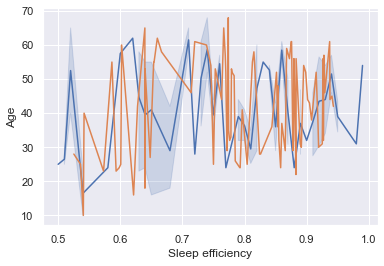

In [55]:
sns.lineplot(x=y_test, y=X_test['Age'])
sns.lineplot(x=cat_predict, y=X_test['Age'])

XG Boost

In [50]:
XGB_model = XGBRegressor(booster='gbtree', max_depth=80, learning_rate=0.3)
XGB_model.fit(X_train_preprocessed, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=80, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', predictor=None, ...)

In [51]:
XGB_predict = XGB_model.predict(X_test_preprocessed)

rmse = np.sqrt(mean_squared_error(y_test, XGB_predict))
print(rmse)

0.05028600763704487


<AxesSubplot:xlabel='Sleep efficiency', ylabel='Age'>

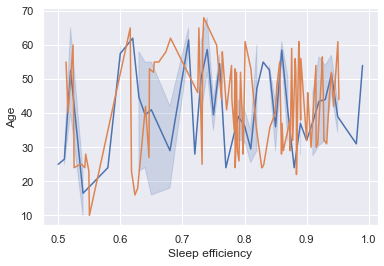

In [49]:
sns.lineplot(x=y_test, y=X_test['Age'])
sns.lineplot(x=XGB_predict, y=X_test['Age'])